# **Imports**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.callbacks import *
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from tensorflow.keras.models import Sequential 
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical


# **Load Data**

In [2]:
data = pd.read_csv("1d_indicators.csv")

In [3]:
data = data.drop(['Date'], axis = 1)

In [4]:
data = data.dropna()

In [5]:
data.head()

,bitcoin-fee_to_reward_raw,difficulty-btc--trx3,hashrate-btc--mom3,hashrate-btc--mom7,hashrate-btc--mom30,hashrate-btc--trx3,hashrate-btc--rsi7,hashrate-btc--rsi14,hashrate-btc--roc3,hashrate-btc--roc7,...,top100cap-btc--rsi7,activeaddresses-btc--mom7,activeaddresses-btc--mom14,activeaddresses-btc--trx3,activeaddresses-btc--rsi7,price-btc--trx3,price-btc--rsi3,price-btc--rsi14,price-btc--roc3,1d_binary_price_change
0,0.867,0.845,6.431394e+12,1.339752e+13,3.328936e+13,3.200,68.982,65.815,10.888,25.713,...,77.854,9581.0,16890.0,-1.376,53.060,3.723,99.456,95.075,9.383,1.0
1,1.338,0.520,3.737455e+12,1.161033e+13,2.889860e+13,3.023,61.645,61.746,6.432,23.112,...,80.298,18862.0,23132.0,1.849,64.122,5.184,99.811,96.416,23.206,1.0
2,1.596,0.314,5.716892e+12,1.457177e+13,2.264479e+13,1.982,58.516,60.024,10.479,31.887,...,74.565,34385.0,44294.0,6.045,71.534,6.968,99.902,97.190,34.759,1.0
3,1.948,0.187,-1.022966e+13,1.791590e+12,2.095298e+13,0.067,49.262,54.803,-15.617,3.350,...,74.737,14427.0,39163.0,7.371,72.299,7.181,99.919,97.368,30.456,1.0
4,1.432,0.689,-1.003014e+13,-7.255264e+12,1.805297e+13,-1.729,43.687,51.468,-16.218,-12.282,...,52.947,16760.0,25062.0,5.263,62.394,6.652,99.941,97.602,19.411,1.0


In [6]:
data.shape

(2831, 79)

We use iloc to allocate variable X to all features exept the last column which is the dependent variable that is allocated to y.

In [7]:
X = data.iloc[:,:-1]

In [8]:
y = data.iloc[:,-1:]

We perform a 80/20 Train Test split. Shuffling is not ideal since LSTM relies on sequential data.

In [9]:
X_train, X_test, y_train, y_test =train_test_split(X,y, test_size=0.2, train_size=0.8, shuffle=False, random_state=7)

In [10]:
X_train.shape

(2264, 78)

# Scaling
We create an empty list and append it first with a RobustScaler (removes outliers by removing median and scaling the data according to the quantile range. Default: Interquartile Range), and then with the MinMaxScaler which forces all values to range from 0 to 1 (or -1 to 1 if there are negative values). In pass these scaler transforms in sequence, we use scikit-learn's Pipeline utility.

In [11]:
list=[]

In [12]:
list.append(['RobustScaler',RobustScaler()])

In [13]:
list.append(['MinMaxScaler',MinMaxScaler()])

In [14]:
scale=Pipeline(list,verbose=True)

In [15]:
X_train=scale.fit_transform(X_train)

[Pipeline] ...... (step 1 of 2) Processing RobustScaler, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing MinMaxScaler, total=   0.0s


In [16]:
X_train.shape

(2264, 78)

In [17]:
X_test=scale.transform(X_test)

Reshaping needed to fit the required 3-d input in the model

In [18]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))

In [19]:
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [20]:
y_train=y_train.values

Convert dependent variable to tpye "categorical".

In [21]:
unique1, id1 = np.unique(y_train, return_inverse=True)

In [22]:
y_train=to_categorical(id1,num_classes=2)

In [23]:
y_train.shape

(2264, 2)

In [24]:
y_train=np.reshape(y_train, (y_train.shape[0],1,y_train.shape[1]))

In [25]:
y_test=y_test.values

# **Optimizer and Model Training**

First we initiate Keras' LearningRateScheduler which reduces the learning rate and we use (like in the paper) the Adam optimizer with a starting learning rate of 0.001

In [26]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch/1000))

In [27]:
adam=optimizers.Adam(lr=1e-3,amsgrad=True)

We define a sequential model with 300 LSTM units in three hidden layers and a Dense output layer with two units (units determine the dimensionality of the output space. Two, since we have binary classification)

In [28]:
model = Sequential()
model.add(LSTM(300, return_sequences=True, activation='relu', input_shape=(1, X_train.shape[2])))
model.add(LSTM(300, return_sequences=True, activation='relu'))
model.add(LSTM(300, return_sequences=True, activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])

ModelCheckpoint saves an intermediate checkpoint if the model is considered "best", so the "best" model can be loaded

In [29]:
path = 'C:/Users/shara/Documents/FinanceAndML-main/data/categorical/01-04-2013-31-12-2020/Best_LSTM_Class_interval3_1d.hdf5'
best_model = ModelCheckpoint(path, save_best_only=True, monitor='val_loss', mode='max')
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='max')

In [30]:
model.fit(X_train,y_train, epochs=5000, batch_size=32, validation_split=0.1,validation_freq=1, shuffle=False,use_multiprocessing=True, callbacks=[best_model,earlyStopping])

Epoch 1/5000
64/64 [==============================] - 1s 19ms/step - loss: 0.6921 - accuracy: 0.5493 - val_loss: 0.6875 - val_accuracy: 0.5551
Epoch 2/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.6913 - accuracy: 0.5488 - val_loss: 0.6876 - val_accuracy: 0.5551
Epoch 3/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6899 - accuracy: 0.5488 - val_loss: 0.6870 - val_accuracy: 0.5551
Epoch 4/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6895 - accuracy: 0.5488 - val_loss: 0.6865 - val_accuracy: 0.5551
Epoch 5/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6898 - accuracy: 0.5488 - val_loss: 0.6869 - val_accuracy: 0.5551
Epoch 6/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6891 - accuracy: 0.5488 - val_loss: 0.6861 - val_accuracy: 0.5551
Epoch 7/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6896 - accuracy: 0.5488 - val_loss: 0.6867 - val_accuracy: 0.5551

Epoch 58/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6616 - accuracy: 0.5866 - val_loss: 0.7027 - val_accuracy: 0.5727
Epoch 59/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6530 - accuracy: 0.5920 - val_loss: 0.7021 - val_accuracy: 0.5595
Epoch 60/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6634 - accuracy: 0.5852 - val_loss: 0.7095 - val_accuracy: 0.5727
Epoch 61/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6573 - accuracy: 0.5788 - val_loss: 0.6973 - val_accuracy: 0.5771
Epoch 62/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6579 - accuracy: 0.5906 - val_loss: 0.7061 - val_accuracy: 0.5727
Epoch 63/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6525 - accuracy: 0.5901 - val_loss: 0.7053 - val_accuracy: 0.5595
Epoch 64/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6534 - accuracy: 0.5866 - val_loss: 0.6945 - val_accuracy:

Epoch 115/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6291 - accuracy: 0.6087 - val_loss: 0.7757 - val_accuracy: 0.5903
Epoch 116/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6257 - accuracy: 0.6161 - val_loss: 0.8058 - val_accuracy: 0.5903
Epoch 117/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6230 - accuracy: 0.6181 - val_loss: 0.7312 - val_accuracy: 0.5683
Epoch 118/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.6230 - accuracy: 0.6161 - val_loss: 0.8758 - val_accuracy: 0.5110
Epoch 119/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6165 - accuracy: 0.6269 - val_loss: 0.7951 - val_accuracy: 0.5683
Epoch 120/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6173 - accuracy: 0.6166 - val_loss: 0.8073 - val_accuracy: 0.5859
Epoch 121/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6136 - accuracy: 0.6220 - val_loss: 0.7608 - val_ac

64/64 [==============================] - 1s 12ms/step - loss: 0.6020 - accuracy: 0.6460 - val_loss: 0.8838 - val_accuracy: 0.5727
Epoch 172/5000
64/64 [==============================] - 1s 11ms/step - loss: 0.5875 - accuracy: 0.6421 - val_loss: 0.7794 - val_accuracy: 0.5815
Epoch 173/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.5861 - accuracy: 0.6431 - val_loss: 0.9918 - val_accuracy: 0.5727
Epoch 174/5000
64/64 [==============================] - 1s 11ms/step - loss: 0.5750 - accuracy: 0.6568 - val_loss: 0.8658 - val_accuracy: 0.5771
Epoch 175/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.5650 - accuracy: 0.6544 - val_loss: 0.9012 - val_accuracy: 0.5595
Epoch 176/5000
64/64 [==============================] - 1s 11ms/step - loss: 0.5649 - accuracy: 0.6588 - val_loss: 0.8687 - val_accuracy: 0.5595
Epoch 177/5000
64/64 [==============================] - 1s 11ms/step - loss: 0.5581 - accuracy: 0.6662 - val_loss: 0.9245 - val_accuracy: 0.5595


64/64 [==============================] - 1s 12ms/step - loss: 0.5328 - accuracy: 0.6986 - val_loss: 1.0281 - val_accuracy: 0.4802
Epoch 228/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6017 - accuracy: 0.6622 - val_loss: 0.8071 - val_accuracy: 0.5595
Epoch 229/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6205 - accuracy: 0.6436 - val_loss: 0.9011 - val_accuracy: 0.5727
Epoch 230/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.5600 - accuracy: 0.6892 - val_loss: 1.0874 - val_accuracy: 0.5551
Epoch 231/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.5448 - accuracy: 0.6932 - val_loss: 1.2611 - val_accuracy: 0.5286
Epoch 232/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.5206 - accuracy: 0.7113 - val_loss: 1.0859 - val_accuracy: 0.4978
Epoch 233/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.5188 - accuracy: 0.7059 - val_loss: 0.9229 - val_accuracy: 0.5330


64/64 [==============================] - 1s 13ms/step - loss: 0.4089 - accuracy: 0.7806 - val_loss: 1.6055 - val_accuracy: 0.5242
Epoch 284/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.4053 - accuracy: 0.7889 - val_loss: 1.6473 - val_accuracy: 0.5066
Epoch 285/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.4022 - accuracy: 0.7820 - val_loss: 1.6582 - val_accuracy: 0.5022
Epoch 286/5000
64/64 [==============================] - 1s 11ms/step - loss: 0.4006 - accuracy: 0.7835 - val_loss: 1.6378 - val_accuracy: 0.5066
Epoch 287/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.4010 - accuracy: 0.7884 - val_loss: 1.6470 - val_accuracy: 0.5022
Epoch 288/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.4724 - accuracy: 0.7521 - val_loss: 1.1985 - val_accuracy: 0.4978
Epoch 289/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.6570 - accuracy: 0.6794 - val_loss: 1.1467 - val_accuracy: 0.5507


64/64 [==============================] - 1s 12ms/step - loss: 0.3119 - accuracy: 0.8478 - val_loss: 2.2629 - val_accuracy: 0.5154
Epoch 340/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.3171 - accuracy: 0.8439 - val_loss: 2.1743 - val_accuracy: 0.5110
Epoch 341/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.3110 - accuracy: 0.8498 - val_loss: 2.2926 - val_accuracy: 0.5066
Epoch 342/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.3091 - accuracy: 0.8488 - val_loss: 2.2256 - val_accuracy: 0.5154
Epoch 343/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.3157 - accuracy: 0.8429 - val_loss: 2.2610 - val_accuracy: 0.5286
Epoch 344/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.3025 - accuracy: 0.8552 - val_loss: 2.3262 - val_accuracy: 0.5022
Epoch 345/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.3239 - accuracy: 0.8439 - val_loss: 2.0950 - val_accuracy: 0.4890


64/64 [==============================] - 1s 12ms/step - loss: 0.2665 - accuracy: 0.8837 - val_loss: 2.3498 - val_accuracy: 0.5110
Epoch 396/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.2924 - accuracy: 0.8616 - val_loss: 2.4221 - val_accuracy: 0.5242
Epoch 397/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.2383 - accuracy: 0.8920 - val_loss: 2.4839 - val_accuracy: 0.5286
Epoch 398/5000
64/64 [==============================] - 1s 11ms/step - loss: 0.2235 - accuracy: 0.8945 - val_loss: 2.5958 - val_accuracy: 0.4978
Epoch 399/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.2304 - accuracy: 0.8959 - val_loss: 2.5504 - val_accuracy: 0.5022
Epoch 400/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.2364 - accuracy: 0.8881 - val_loss: 2.5282 - val_accuracy: 0.5198
Epoch 401/5000
64/64 [==============================] - 1s 11ms/step - loss: 0.2077 - accuracy: 0.9102 - val_loss: 2.5297 - val_accuracy: 0.5022


64/64 [==============================] - 1s 12ms/step - loss: 0.1378 - accuracy: 0.9401 - val_loss: 2.9411 - val_accuracy: 0.5727
Epoch 452/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.1366 - accuracy: 0.9396 - val_loss: 2.9561 - val_accuracy: 0.5639
Epoch 453/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.1336 - accuracy: 0.9431 - val_loss: 2.9510 - val_accuracy: 0.5639
Epoch 454/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.1311 - accuracy: 0.9431 - val_loss: 3.0221 - val_accuracy: 0.5595
Epoch 455/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.1295 - accuracy: 0.9440 - val_loss: 3.0234 - val_accuracy: 0.5595
Epoch 456/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.1276 - accuracy: 0.9475 - val_loss: 3.0518 - val_accuracy: 0.5595
Epoch 457/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.1262 - accuracy: 0.9489 - val_loss: 3.0375 - val_accuracy: 0.5507


64/64 [==============================] - 1s 13ms/step - loss: 0.1174 - accuracy: 0.9553 - val_loss: 3.2394 - val_accuracy: 0.5286
Epoch 508/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.1174 - accuracy: 0.9514 - val_loss: 3.2263 - val_accuracy: 0.5286
Epoch 509/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.1153 - accuracy: 0.9519 - val_loss: 3.1993 - val_accuracy: 0.5286
Epoch 510/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.1232 - accuracy: 0.9509 - val_loss: 3.4330 - val_accuracy: 0.5463
Epoch 511/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.2132 - accuracy: 0.9234 - val_loss: 2.9055 - val_accuracy: 0.5463
Epoch 512/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.4450 - accuracy: 0.8665 - val_loss: 2.7824 - val_accuracy: 0.5242
Epoch 513/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.4827 - accuracy: 0.8238 - val_loss: 2.5423 - val_accuracy: 0.5022


64/64 [==============================] - 1s 12ms/step - loss: 0.0555 - accuracy: 0.9823 - val_loss: 3.4048 - val_accuracy: 0.5463
Epoch 564/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0518 - accuracy: 0.9833 - val_loss: 3.4818 - val_accuracy: 0.5374
Epoch 565/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0525 - accuracy: 0.9828 - val_loss: 3.5044 - val_accuracy: 0.5419
Epoch 566/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.0508 - accuracy: 0.9848 - val_loss: 3.5425 - val_accuracy: 0.5330
Epoch 567/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0512 - accuracy: 0.9838 - val_loss: 3.5393 - val_accuracy: 0.5419
Epoch 568/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.0529 - accuracy: 0.9818 - val_loss: 3.5725 - val_accuracy: 0.5419
Epoch 569/5000
64/64 [==============================] - 1s 13ms/step - loss: 0.0519 - accuracy: 0.9818 - val_loss: 3.5743 - val_accuracy: 0.5330


64/64 [==============================] - 1s 12ms/step - loss: 0.1316 - accuracy: 0.9435 - val_loss: 3.3506 - val_accuracy: 0.5066
Epoch 620/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0761 - accuracy: 0.9764 - val_loss: 3.3930 - val_accuracy: 0.5198
Epoch 621/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0650 - accuracy: 0.9794 - val_loss: 3.3459 - val_accuracy: 0.5463
Epoch 622/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0471 - accuracy: 0.9877 - val_loss: 3.3603 - val_accuracy: 0.5551
Epoch 623/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0419 - accuracy: 0.9897 - val_loss: 3.4455 - val_accuracy: 0.5595
Epoch 624/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0393 - accuracy: 0.9912 - val_loss: 3.5052 - val_accuracy: 0.5595
Epoch 625/5000
64/64 [==============================] - 1s 12ms/step - loss: 0.0374 - accuracy: 0.9926 - val_loss: 3.5251 - val_accuracy: 0.5419


# **Testing**

In [31]:
prediction_model = load_model(path,compile=False)

In [32]:
y_pred = prediction_model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


# Metrics

Metrics used in the paper: Accuracy, F1 score, and Area under curve

In [33]:
acc=accuracy_score(y_test,y_pred)
acc

0.5114638447971781

In [34]:
f1=f1_score(y_test,y_pred,average='binary')
f1

0.5553772070626004

In [35]:
auc=roc_auc_score(y_test,y_pred)
auc

0.5067128817128816

In [36]:
print(classification_report(y_test,y_pred,labels=[0,1], target_names=['decrease','increase']))

              precision    recall  f1-score   support

    decrease       0.46      0.45      0.46       259
    increase       0.55      0.56      0.56       308

    accuracy                           0.51       567
   macro avg       0.51      0.51      0.51       567
weighted avg       0.51      0.51      0.51       567



Confustion Matrix

In [ ]:
pip install scikit-plot

[[117 142]
 [135 173]]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

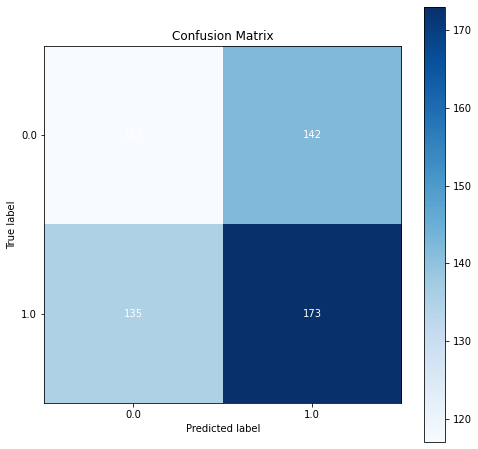

In [37]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,figsize=(8,8))